In [2]:
!pip install tensorflow==2.9.0

^C


     -------------------------------------- 444.1/444.1 MB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 1.6/1.6 MB 4.5 MB/s eta 0:00:00
     -------------------------------------- 438.7/438.7 kB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 4.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 22.10.26
    Uninstalling flatbuffers-22.10.26:
      Successfully uninstalled flatbuffers-22.10.26
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successful

In [3]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

print(tf. __version__)


RANDOM_SEED = 42

2.9.0


# Specify each path

In [4]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'
tfjs_save_path = 'model/keypoint_classifier/tfjs_model'

# Set number of classes

In [5]:
NUM_CLASSES = 5

# Dataset reading

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [7]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [12]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
24/30 [=======================>......] - ETA: 0s - loss: 1.5810 - accuracy: 0.2728 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
30/30 [==============================] - 1s 20ms/step - loss: 1.5611 - accuracy: 0.2969 - val_loss: 1.4033 - val_accuracy: 0.4552
Epoch 2/1000
23/30 [======================>.......] - ETA: 0s - loss: 1.4012 - accuracy: 0.4361
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
30/30 [==============================] - 0s 5ms/step - loss: 1.3897 - accuracy: 0.4417 - val_loss: 1.2512 - val_accuracy: 0.5210
Epoch 3/1000
25/30 [========================>.....] - ETA: 0s - loss: 1.2789 - accuracy: 0.4872
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
30/30 [==============================] - 0s 4ms/step - loss: 1.2737 - accuracy: 0.4911 - val_loss: 1.1047 - val_accuracy: 0.5535
Epoch 4/1000
26/30 [=========================>....] - ETA: 0s - loss: 1.1670 - accuracy: 0.5246

In [14]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 [==============================] - 0s 1ms/step - loss: 0.0161 - accuracy: 0.9968


In [15]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [16]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 73ms/step
[2.2237846e-07 5.9220379e-11 2.4795468e-10 9.9999976e-01 1.4185205e-27]
3


# Confusion matrix

40/40 [==============================] - 0s 888us/step


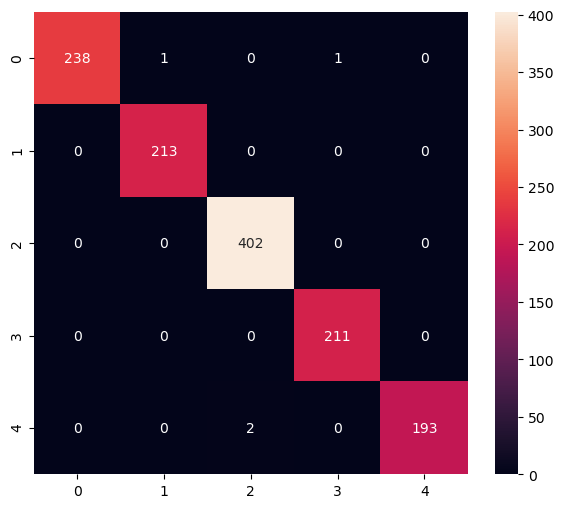

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       240
           1       1.00      1.00      1.00       213
           2       1.00      1.00      1.00       402
           3       1.00      1.00      1.00       211
           4       1.00      0.99      0.99       195

    accuracy                           1.00      1261
   macro avg       1.00      1.00      1.00      1261
weighted avg       1.00      1.00      1.00      1261



In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [19]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [20]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\zayed\AppData\Local\Temp\tmpvnvxd042\assets


6532

In [23]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,tfjs_save_path)

# Inference test

In [24]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [25]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [26]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [27]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 2 ms


In [28]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.2237910e-07 5.9220497e-11 2.4795513e-10 9.9999976e-01 1.4185258e-27]
3
